# Initializatoin

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab\ Notebooks/Deep\ Learning\ Course/HW03

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Deep Learning Course/HW03'

/content


## Imports

In [4]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.nn import Parameter

from name_dataset import Dataset

# RNN

## Traditional RNN

In the introductory section, we delve into the architecture of Recurrent Neural Networks (RNNs) and elucidate their training methodologies. To gain a deeper understanding of RNNs, you're encouraged to explore further [HERE](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-network)

For the task at hand, you've been furnished with the Names dataset, a compilation comprising thousands of surnames from 18 distinct languages of origin. Your objective is to prognosticate the language of origin for a given name, relying solely on its orthography. Your task primarily involves implementing the section demarcated by `#your_code`.

In [5]:
dataset = Dataset()
for i in range(10):
    category, line, _, _ = dataset.randomTrainingExample()
    print('category =', category, '- random name =', line)

Error occurred while downloading data.zip: --2024-05-01 17:29:33--  https://download.pytorch.org/tutorial/data.zip

Resolving download.pytorch.org (download.pytorch.org)... 18.154.144.38, 18.154.144.43, 18.154.144.35, ...

Connecting to download.pytorch.org (download.pytorch.org)|18.154.144.38|:443... connected.

HTTP request sent, awaiting response... 200 OK

Length: 2882130 (2.7M) [application/zip]

Saving to: ‘data.zip’



     0K .......... .......... .......... .......... ..........  1% 5.52M 0s

    50K .......... .......... .......... .......... ..........  3% 6.24M 0s

   100K .......... .......... .......... .......... ..........  5% 25.6M 0s

   150K .......... .......... .......... .......... ..........  7% 10.1M 0s

   200K .......... .......... .......... .......... ..........  8% 21.3M 0s

   250K .......... .......... .......... .......... .......... 10% 37.0M 0s

   300K .......... .......... .......... .......... .......... 12% 22.8M 0s

   350K .......... .......... .

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        #your_code
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):

        #your_code
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.i2h(combined))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = dataset.n_letters
n_categories = dataset.n_categories
rnn = RNN(n_letters, n_hidden, n_categories)

In [8]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(name_tensor.size(0)):
      output, hidden = rnn(name_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


And here you can train your model and see it's performance after each 5000 iterations

5000 5% 2.7222 Henriques is predicted as a "Greek" name, status = ✗ (Portuguese)

10000 10% 1.6583 Mertens is predicted as a "Dutch" name, status = ✓

15000 15% 0.8510 Pham is predicted as a "Vietnamese" name, status = ✓

20000 20% 3.0947 Deeb is predicted as a "German" name, status = ✗ (Arabic)

25000 25% 1.4435 Petit is predicted as a "French" name, status = ✓

30000 30% 1.6702 Farnsworth is predicted as a "English" name, status = ✓

35000 35% 0.1509 Durakov is predicted as a "Russian" name, status = ✓

40000 40% 4.0178 Vild is predicted as a "English" name, status = ✗ (Russian)

45000 45% 0.7192 Le is predicted as a "Vietnamese" name, status = ✓

50000 50% 1.4528 Krebs is predicted as a "Dutch" name, status = ✗ (German)

55000 55% 0.6408 Lesauvage is predicted as a "French" name, status = ✓

60000 60% 3.3572 Tomas is predicted as a "Arabic" name, status = ✗ (Spanish)

65000 65% 1.8997 Broz is predicted as a "Spanish" name, status = ✗ (Polish)

70000 70% 0.0618 Quang is predicted as 

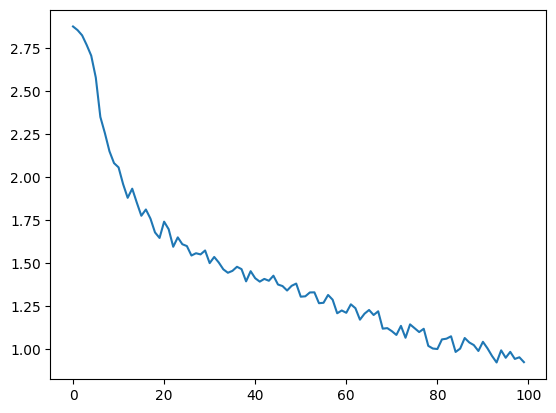

In [13]:
n_iters = 100000
print_every = 5000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, _ = dataset.categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s is predicted as a "%s" name, status = %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    if iter % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

## Traditional RNN Disadvantages

In this part, we aim to delve into the limitations of traditional RNNs:
1.   Recurrent computation is slow
2.   They have difficulty accessing information from many steps back.

You are provided with a simple code that helps you to give the idea better. By modifying this code, you are able to demonstrate the mentioned disadvantages, but you are also free to change the code if needed or use any dataset you want.

**Question:** Do you think using GPU instead of CPU completely solves the first problem?
Using a GPU instead of a CPU can significantly alleviate the issue of slow recurrent computation in RNNs.
However, it's essential to note that while using a GPU can significantly speed up computation, it may not completely solve the problem, especially for very large or complex models. There might still be limitations imposed by the sequential nature of RNNs, such as the need to wait for the completion of computations from previous time steps before proceeding to the next one. Additionally, other factors such as memory bandwidth and model architecture can also impact overall performance.
Also we should note that Rnn's inherently have sequentially dependency, so we have limitations in parallelism.


Note: The main goal of this part is to help you understand these problems better. Don't be too hard to implement and delivery.

Epoch [10/100], Loss: 1.0264

Epoch [20/100], Loss: 0.9142

Epoch [30/100], Loss: 0.8066

Epoch [40/100], Loss: 0.6953

Epoch [50/100], Loss: 0.5712

Epoch [60/100], Loss: 0.4352

Epoch [70/100], Loss: 0.3006

Epoch [80/100], Loss: 0.1873

Epoch [90/100], Loss: 0.1116

Epoch [100/100], Loss: 0.0742


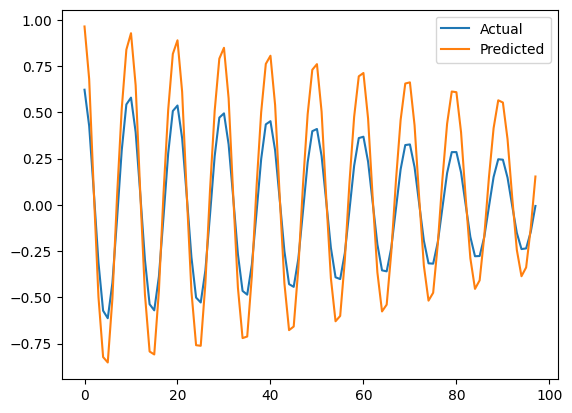

In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate sinusoidal temperature data with decreasing range over time
np.random.seed(0)
num_periods = 50
timesteps_per_period = 10
total_timesteps = num_periods * timesteps_per_period

# Generate decreasing factor
decreasing_factor = np.linspace(1, 0.1, total_timesteps)

# Generate temperature data with decreasing sinusoidal range
temperature_data = np.sin(np.linspace(0, 2*np.pi*num_periods, total_timesteps)) * decreasing_factor

# Normalize the data
temperature_data = (temperature_data - np.mean(temperature_data)) / np.std(temperature_data)

# Convert numpy array to PyTorch tensor
temperature_data = torch.tensor(temperature_data, dtype=torch.float32).view(-1, 1)

# Define function to create dataset with sinusoidal pattern
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        seq_in = data[i:i+seq_length]
        seq_out = data[i+seq_length]
        X.append(seq_in)
        Y.append(seq_out)
    return torch.stack(X), torch.stack(Y)

# Define sequence length and create dataset
sequence_length = 10  # Number of previous days to look at for prediction
X, Y = create_dataset(temperature_data, sequence_length)

# Split the dataset into train and test sets
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = 1
hidden_size = 10
output_size = 1

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Plot actual vs predicted
plt.plot(Y_test.numpy(), label='Actual')
plt.plot(test_predictions.numpy(), label='Predicted')
plt.legend()
plt.show()

# LSTM Preparation

Now that you have experience with traditional RNNs, it's time to implement the LSTM model. Your goal is to implement the cell and model for LSTM architecture. The proposed dataset for this section is MNIST, allowing you to focus solely on model implementation.

In [15]:
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor())

batch_size = 128
n_iters = 6000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))


Failed to download (trying next):

HTTP Error 503: Service Unavailable






100%|██████████| 9912422/9912422 [00:00<00:00, 18009401.22it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw






100%|██████████| 28881/28881 [00:00<00:00, 414511.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw





Failed to download (trying next):

HTTP Error 503: Service Unavailable






100%|██████████| 1648877/1648877 [00:01<00:00, 1135746.02it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw






100%|██████████| 4542/4542 [00:00<00:00, 23232352.16it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## LSTM Cells

In [17]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: (batch_size, input_size)
        #       hx: (batch_size, hidden_size)
        # Outputs:
        #       hy: (batch_size, hidden_size)
        #       cy: (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
            hx = (hx, hx)

        hx, cx = hx
        gates = self.xh(input) + self.hh(hx)

        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh(cell_gate)
        o_t = torch.sigmoid(output_gate)

        cy = torch.mul(f_t, cx) + torch.mul(i_t, g_t)
        hy = torch.mul(o_t, torch.tanh(cy))

        return hy, cy

## LSTM Models

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)



    def forward(self, x):

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        hn, cn = h0[0,:,:], c0[0,:,:]
        outs = []

        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))
            outs.append(hn)

        out = torch.stack(outs, dim=1)

        out = self.fc(out[:, -1, :])

        return out

In [19]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY 1 OR 2
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [22]:
# your code
num_epochs = 5
iter_count = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        model.train()

        optimizer.zero_grad()

        images = images.view(-1, 28, 28)
        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter_count += 1

        if iter_count % 500 == 0:
            model.eval()
            correct = 0
            total = 0
            test_loss = 0.0

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.view(-1, 28, 28)
                    outputs = model(images)
                    test_loss += criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            print(f"Iteration: {iter_count}, Loss: {loss.item()}, Test Accuracy: {accuracy}%")
# Train model and print Loss and Accuracy on Test Dataset after each 500 iterations

Iteration: 500, Loss: 0.18775498867034912, Test Accuracy: 94.33%

Iteration: 1000, Loss: 0.23256514966487885, Test Accuracy: 95.83%

Iteration: 1500, Loss: 0.08051035553216934, Test Accuracy: 96.73%

Iteration: 2000, Loss: 0.041766297072172165, Test Accuracy: 97.63%


# Sentiment Analysis

Now you are ready to face a real-world problem. In this task, we want you to do a sentiment analysis on the [IMDB dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). The main goal is to reach more than an acceptable accuracy of **75%** on LSTM model. You are free to use torch.nn.LSTM to design your architecture, but you must prepare the IMDB dataset on your own.

In [1]:
!pip3 install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from collections import Counter
from torchsummary import summary
import re
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-05-01 20:26:02.004039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 20:26:02.004130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 20:26:02.143421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
def preprocess_text(text):
    clean_text = re.compile('<.*?>')
    text = re.sub(clean_text, '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    return text

df['review'] = df['review'].apply(preprocess_text)

all_words = ' '.join(df['review']).split()
word_counts = Counter(all_words)
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

word_to_idx = {word: i + 1 for i, (word, _) in enumerate(sorted_word_counts)}

X = []
for review in df['review']:
    seq = [word_to_idx[word] for word in review.split() if word in word_to_idx]
    X.append(seq)

max_seq_len = 250
X_padded = [seq[:max_seq_len] + [0]*(max_seq_len - len(seq)) if len(seq) < max_seq_len else seq[:max_seq_len] for seq in X]

y = df['sentiment'].map({'positive': 1, 'negative': 0}).values


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=137)

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [9]:
input_size = len(word_to_idx) + 1
embedding_dim = 256
hidden_size = 256
num_layers = 2
output_size = 1

model = LSTMModel(input_size, embedding_dim, hidden_size, num_layers, output_size).cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/5], Loss: 0.6933
Epoch [2/5], Loss: 0.6016
Epoch [3/5], Loss: 0.2979
Epoch [4/5], Loss: 0.1620
Epoch [5/5], Loss: 0.0798


In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 87.27%
